# `06-create-figure-2`

In [1]:
import numpy, pandas, pathlib, joblib
from pandas.plotting import scatter_matrix
from cycler import cycler

import matplotlib.pyplot as plt
import seaborn
import scipy.stats

import MDAnalysis
import sbmlcore

pandas.options.display.max_rows=30
pandas.options.display.max_columns=999

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score,  roc_auc_score,  roc_curve

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

pathlib.Path('pdf').mkdir(exist_ok=True)
pathlib.Path('pdf/figure-2').mkdir(exist_ok=True)

/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


## Figure 2a

In [2]:
DATASET = pandas.read_csv('data/ds-traintest-phen.csv')
def find_position(row):
    return int(row.MUTATION[1:-1])
DATASET['POSITION'] = DATASET.apply(find_position, axis=1)
DATASET

,MUTATION,CONSISTENT_PHENOTYPE,POSITION
0,A102V,S,102
1,A134D,S,134
2,A134P,R,134
3,A134S,S,134
4,A134V,R,134
...,...,...,...
659,Y95N,S,95
660,Y99C,S,99
661,Y99D,S,99
662,Y99F,S,99


Make a crosstab so we can pick out codons which tend to have mutations associated with resistance etc

In [3]:
df = pandas.crosstab(DATASET.POSITION, DATASET.CONSISTENT_PHENOTYPE)
df['TOTAL'] = df['S'] + df['R']
df['PROP_R'] = df['R']/df['TOTAL']
df

CONSISTENT_PHENOTYPE,R,S,TOTAL,PROP_R
POSITION,,,,
1,2,1,3,0.666667
2,0,1,1,0.000000
3,1,2,3,0.333333
4,4,1,5,0.800000
5,5,1,6,0.833333
...,...,...,...,...
181,1,1,2,0.500000
182,1,1,2,0.500000
183,1,2,3,0.333333


What is the distribution?

In [4]:
df.PROP_R.value_counts().sort_index()

PROP_R
0.000000    38
0.166667     1
0.200000     3
0.250000    16
0.333333    25
0.400000     2
0.500000    21
0.600000     6
0.666667    19
0.750000     8
0.800000     6
0.833333     2
1.000000    37
Name: count, dtype: int64

First, let's pick up those codons where less than 20% of mutations are associated with resistance

In [5]:
df2 = df[df.PROP_R<=0.2]
'resid ' + ' '.join(str(i) for i in numpy.sort(df2.index.unique()))

'resid 2 11 15 20 25 33 37 39 40 45 50 53 56 60 61 64 73 74 80 83 84 87 91 95 98 99 100 102 107 111 112 113 121 126 141 144 148 157 167 169 178 185'

Then those where greater than 80% are associated with resistance

In [6]:
df2 = df[df.PROP_R>=0.8]
'resid ' + ' '.join(str(i) for i in numpy.sort(df2.index.unique()))

'resid 4 5 7 8 10 12 13 14 24 31 41 47 49 51 54 57 62 63 68 69 71 72 76 93 94 96 97 103 104 108 116 119 132 135 138 139 142 146 155 159 164 165 170 175 180'

..and finally those where between 40 and 60% of mutations are associated with resistance

In [7]:
df2 = df[(df.PROP_R>=0.4) & (df.PROP_R<=0.6)]
'resid ' + ' '.join(str(i) for i in numpy.sort(df2.index.unique()))

'resid 17 30 32 38 42 44 55 65 70 81 82 90 92 101 105 110 115 118 120 125 133 134 147 154 160 166 181 182 184'

Create a PDB file with the proportion of resistance stored in the `BETA` column

In [8]:
u = MDAnalysis.Universe('data/reference/3PL1-PZA.pdb')

positions = df[(df.PROP_R==0)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 0

positions = df[(df.PROP_R>0) & (df.PROP_R<0.2)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 16.667

positions = df[(df.PROP_R==0.2)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 20

positions = df[(df.PROP_R==0.25)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 25

positions = df[(df.PROP_R>0.25) & (df.PROP_R<0.4)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 33.3333

positions = df[(df.PROP_R==0.4)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 40

positions = df[(df.PROP_R==0.5)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 50

positions = df[(df.PROP_R==0.6)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 60

positions = df[(df.PROP_R>0.6) & (df.PROP_R<0.7)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 66.66667

positions = df[(df.PROP_R==0.75)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 75

positions = df[(df.PROP_R==0.8)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 80

positions = df[(df.PROP_R>0.8) & (df.PROP_R<0.9)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 83.3333

positions = df[(df.PROP_R==1)].index
a = u.select_atoms('resid ' + ' '.join(str(i) for i in positions))
a.atoms.tempfactors = 100

all = u.select_atoms('all')
all.write('data/reference/3PL1-PZA-beta.pdb')

/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151

## Figure 2b

In [9]:
df = pandas.read_csv('data/ds-traintest-phen-features.csv')
dataset = sbmlcore.FeatureDataset(df, species='M. tuberculosis', gene='pncA')
dataset.df

,mutation,segid,phenotype,d_volume,d_hydropathy_KD,d_Pi,d_MW,d_rogov,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,secondary_structure_codes,temp_factor,depth,deep_ddG,rasp_score_ml,snap2_score,dist_FE2,dist_PZA,mcsm_stability_ddG,mapp_score
0,M1L,A,R,3.8,1.9,0.24,-18.0,-0.389,0.00,-35.20,86.2,2.0,0.0,4,59.720001,2.103049,-0.770,-0.107405,20,29.948318,27.641663,-0.771,13.49
1,M1T,A,R,-46.8,-2.6,-0.14,-30.1,-0.548,0.00,-35.20,86.2,2.0,0.0,4,59.720001,2.103049,-1.096,0.655765,52,29.948318,27.641663,-0.367,25.97
2,M1V,A,S,-22.9,2.3,0.22,-32.1,-0.514,0.00,-35.20,86.2,2.0,0.0,4,59.720001,2.103049,-0.908,0.364061,4,29.948318,27.641663,-0.912,30.01
3,R2Q,A,S,-29.6,1.0,-5.11,-28.0,0.375,-117.94,133.99,54.7,2.0,0.0,0,53.990002,2.372958,-1.144,1.246086,-26,27.459823,24.722696,-0.790,2.68
4,A3E,A,R,49.8,-5.3,-2.78,58.0,-0.033,-126.53,153.85,0.0,1.0,1.0,0,43.310001,5.503930,-5.340,3.546088,56,24.149025,21.557456,-2.528,35.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,S185G,A,S,-28.9,0.4,0.29,-30.0,0.120,-73.76,0.00,67.6,0.0,0.0,4,53.709999,1.798143,-0.900,0.561510,69,27.305858,22.750537,-0.597,3.20
660,S185I,A,S,77.7,5.3,0.34,26.1,-0.026,-73.76,0.00,67.6,0.0,0.0,4,53.709999,1.798143,0.128,-0.237151,62,27.305858,22.750537,-0.234,2.82
661,S185N,A,S,25.1,-2.7,-0.27,27.0,0.271,-73.76,0.00,67.6,0.0,0.0,4,53.709999,1.798143,-1.120,-0.031213,53,27.305858,22.750537,-0.277,1.51
662,S185R,A,S,84.4,-3.7,5.08,69.1,0.127,-73.76,0.00,67.6,0.0,0.0,4,53.709999,1.798143,-0.811,0.571823,67,27.305858,22.750537,-0.124,2.78


In [10]:
def return_colour(row):
    if row.phenotype == 'R':
        return '#e41a1c'
    elif row.phenotype == 'S':
        return '#377eb8'
    else:
        return(None)

dataset.df['phenotype_colour'] = dataset.df.apply(return_colour, axis=1)

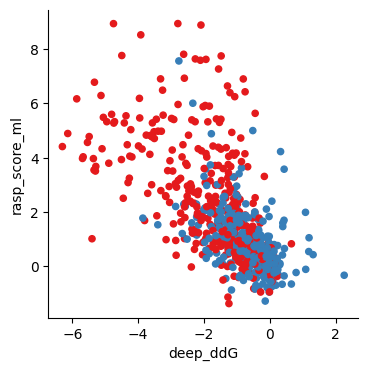

In [11]:
axes = dataset.df.plot.scatter(x='deep_ddG', y='rasp_score_ml', c='phenotype_colour', figsize=(4,4))
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.get_figure().savefig('pdf/figure-2/fig-2b-deepddG-rasp.pdf',bbox_inches='tight',transparent=True)

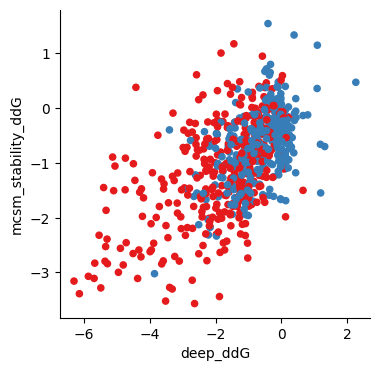

In [12]:
axes = dataset.df.plot.scatter(y='mcsm_stability_ddG', x='deep_ddG', c='phenotype_colour', figsize=(4,4))
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.get_figure().savefig('pdf/figure-2/fig-2b-deepddG-mcmsddG.pdf',bbox_inches='tight',transparent=True)

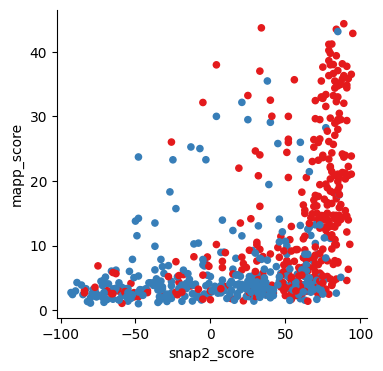

In [13]:
axes = dataset.df.plot.scatter(y='mapp_score', x='snap2_score', c='phenotype_colour', figsize=(4,4))
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xticks([-100, -50, 0, 50, 100])
axes.get_figure().savefig('pdf/figure-2/fig-2b-snap2-mapp.pdf',bbox_inches='tight',transparent=True)

## Figure 2c

We need to split into preliminary Training and Test datasets so the univariate logistic regression is ONLY on the Training set so our decisions remain unaware of the Test data. Use a known seed so we can resplit reproducibily after having done this analysis

In [14]:
random_state=42
mutations ={}

df = pandas.read_csv('data/ds-traintest-phen-features.csv')
mutations['tt'] = df['mutation']
features = df.iloc[:,3:]
labels = df['phenotype'].map({'S':0, 'R':1})
df['phenotype'].value_counts()

phenotype
R    349
S    315
Name: count, dtype: int64

Split the testtrain dataset and scale the numerical data (based on a fit *only* on the training dataset)

In [15]:
mutations_train, mutations_test, X_train, X_test, Y_train, Y_test = train_test_split(mutations['tt'], features, labels, test_size=0.3,
                                                    random_state=random_state)
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

numerical_attribs = list(features)

headings = '\n'.join(i for i in numerical_attribs)

OUTPUT = open('data/ds-traintest-numericalattribs.txt', 'w')
OUTPUT.write(headings)
OUTPUT.close()

pipe = Pipeline([
    ('selector', DataFrameSelector(numerical_attribs)),
    ('scaling', RobustScaler())
    ])

X_train = pipe.fit_transform(X_train)    
Y_train = Y_train.squeeze().to_numpy()
Z_train = mutations_train.to_numpy()

# let's save the pipeline to preserve the scaling etc
joblib.dump(pipe, 'data/pipeline.pkl')

X_test = pipe.transform(X_test)
Y_test = Y_test.squeeze().to_numpy()   
Z_test = mutations_test.to_numpy()

with open('data/ds-train.npy', 'wb') as f:
    numpy.save(f, Y_train)
    numpy.save(f, X_train)
    numpy.save(f, Z_train)

with open('data/ds-test.npy', 'wb') as f:
    numpy.save(f, Y_test)
    numpy.save(f, X_test)    
    numpy.save(f, Z_test)    

df.loc[df.mutation.isin(mutations_test), 'set'] = 'test'
df.loc[df.mutation.isin(mutations_train), 'set'] = 'train'
df.to_csv('data/ds-traintest-phen-features-set.csv',index=False)

Let's check the % resistance is about the same between the train and test datasets

In [16]:
pandas.crosstab(df.set,df.phenotype,margins=True)

phenotype,R,S,All
set,,,
test,103,97,200
train,246,218,464
All,349,315,664


Now we are in a position to do a univariate logistical regression to see how good these features are, and if any are so poor they can be discarded

In [17]:
model_logistic_regression = LogisticRegression()

with open('data/ds-train.npy', 'rb') as f:
    Y_train_prepared = numpy.load(f)
    X_train_prepared = numpy.load(f)

with open('data/ds-traintest-numericalattribs.txt') as f:
    numerical_attribs = f.readlines()

In [18]:
numerical_attribs

['d_volume\n',
 'd_hydropathy_KD\n',
 'd_Pi\n',
 'd_MW\n',
 'd_rogov\n',
 'phi\n',
 'psi\n',
 'residue_sasa\n',
 'n_hbond_acceptors\n',
 'n_hbond_donors\n',
 'secondary_structure_codes\n',
 'temp_factor\n',
 'depth\n',
 'deep_ddG\n',
 'rasp_score_ml\n',
 'snap2_score\n',
 'dist_FE2\n',
 'dist_PZA\n',
 'mcsm_stability_ddG\n',
 'mapp_score']

In [19]:
fpr = {}
tpr = {}
roc = {}
recall = {}

rows={}
rows['feature'] = []
rows['roc'] = []

for i in range(len(numerical_attribs)):

    attribute = numerical_attribs[i].rstrip()

    model_logistic_regression.fit(X_train_prepared[:,i:i+1], Y_train_prepared)

    Y_probs = cross_val_predict(model_logistic_regression, X_train_prepared[:,i:i+1], Y_train_prepared, cv=3, method='predict_proba', n_jobs=-1)
    
    Y_scores = Y_probs[:,1]

    # mask = (Y_scores>0.6) | (Y_scores<0.4)

    fpr[attribute], tpr[attribute], thresholds = roc_curve(Y_train_prepared, Y_scores)

    roc[attribute] = roc_auc_score(Y_train_prepared, Y_scores)

    Y_train_predicted = model_logistic_regression.predict(X_train_prepared[:,i:i+1])

    recall[attribute] = recall_score(Y_train_prepared, Y_train_predicted)

    rows['roc'].append(roc[attribute])
    rows['feature'].append(attribute)

    
df = pandas.DataFrame(rows)
df.sort_values(by='roc', ascending=True, inplace=True)
df

,feature,roc
10,secondary_structure_codes,0.479321
3,d_MW,0.496989
5,phi,0.503645
0,d_volume,0.514032
2,d_Pi,0.524092
8,n_hbond_acceptors,0.539019
9,n_hbond_donors,0.550058
6,psi,0.575063
4,d_rogov,0.593738
1,d_hydropathy_KD,0.597803


Let's discard some features not shown to be predictive using an arbitrary minimum AUC ROC of 0.55 

In [20]:
df[df.roc<0.55]

,feature,roc
10,secondary_structure_codes,0.479321
3,d_MW,0.496989
5,phi,0.503645
0,d_volume,0.514032
2,d_Pi,0.524092
8,n_hbond_acceptors,0.539019


Now that we've identified these six features to drop, we will need to recreate the Train/Test datasets in the next notebook, preserving the splits/random seed etc

In [21]:
list(df[df.roc<0.55].feature)

['secondary_structure_codes',
 'd_MW',
 'phi',
 'd_volume',
 'd_Pi',
 'n_hbond_acceptors']

## Figure S1C

In [22]:
y = df[df.roc>0.55].roc.to_list()
x = df[df.roc>0.55].feature.to_list()

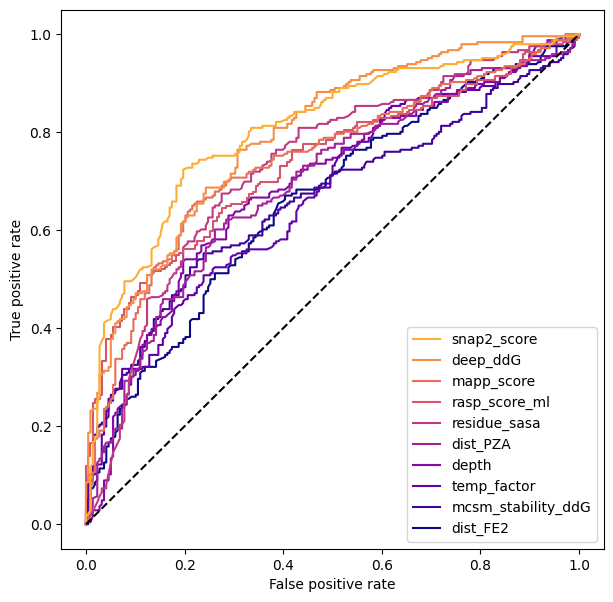

In [23]:
n=11
colors = [plt.get_cmap('plasma')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(cycler('color', colors)))

fig = plt.figure(figsize=(7, 7))
axes = plt.gca()
for i,j in zip(x,y):
    if j > 0.65:
        axes.plot(fpr[i], tpr[i], label=i)
axes.set_xlabel('False positive rate')
axes.set_ylabel('True positive rate')
axes.legend()
axes.plot((0,1), (0,1), 'k--')

handles, labels = axes.get_legend_handles_labels()
axes.legend(reversed(handles), reversed(labels), loc='lower right')

fig.savefig('pdf/figure-2/si-features-auc.pdf',bbox_inches='tight',transparent=True)

## Figure 2B

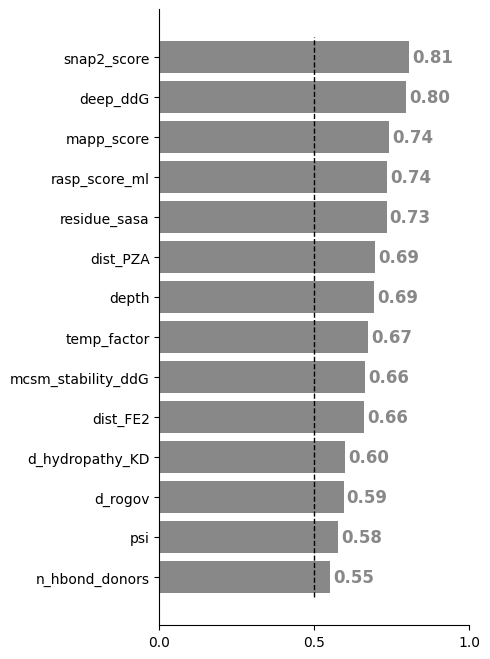

In [24]:
fig = plt.figure(figsize=(4, 8))
axes = plt.gca()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xlim([0,1])
axes.set_xticks([0,0.5,1])
axes.plot([0.5,0.5], (-0.5,13.5), 'k--', lw=1)
axes.barh(x,y, label=y, color='#888888')
for (i,j) in zip(x,y):
    axes.text(j+0.01,i, "%.2f" % (j), ha='left', va='center', color='#888888', fontweight='heavy', fontsize='large')
fig.savefig('pdf/figure-2/fig-2c-bar-features.pdf',bbox_inches='tight',transparent=True)

## Figure S1A,B

/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_35939/3414898158.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=dataset.df, x=feature, y='phenotype', size=3, palette={'S':'#377eb8', 'R':'#e41a1c'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_35939/3414898158.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=dataset.df, x=feature, y='phenotype', size=3, palette={'S':'#377eb8', 'R':'#e41a1c'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_35939/3414898158.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=dataset.df, x=feature, y='phenotype', size=3, palette={'S':'#377eb8', 'R':'#e41a1c'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_35939/3414898158.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot

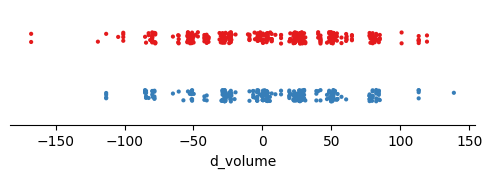

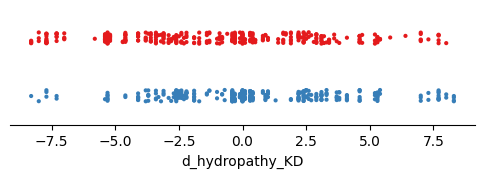

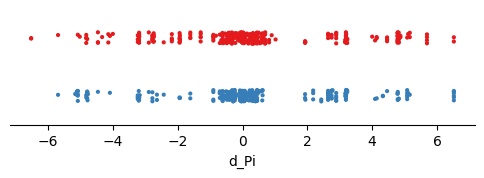

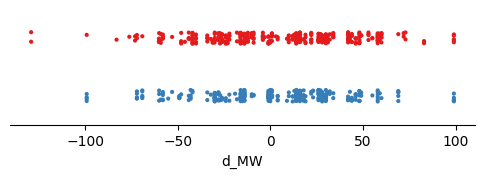

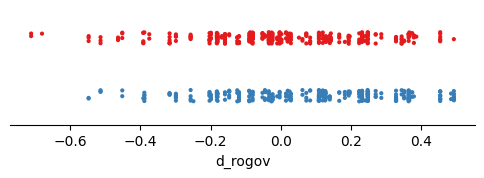

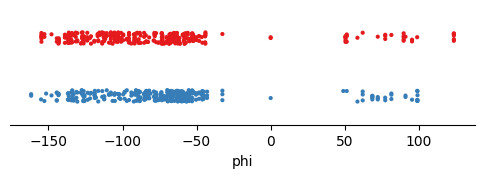

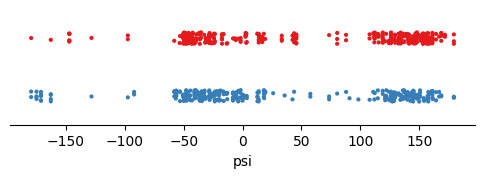

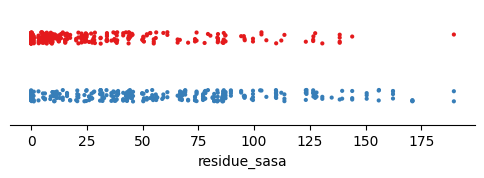

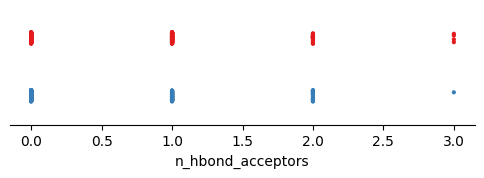

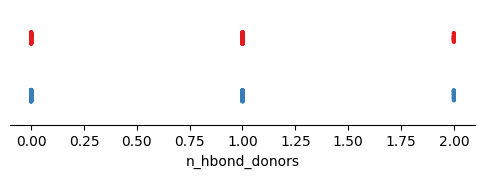

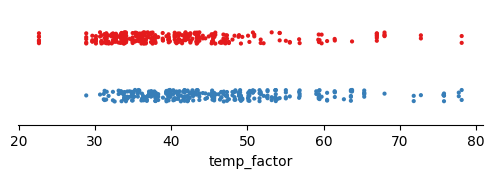

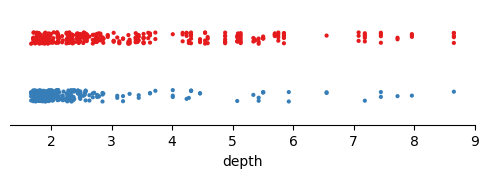

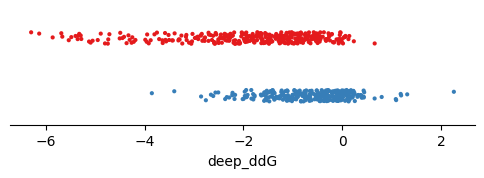

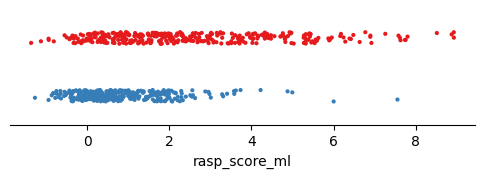

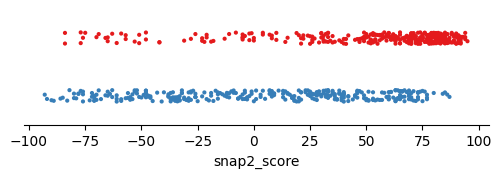

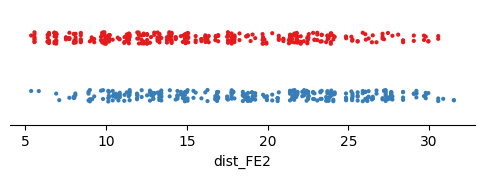

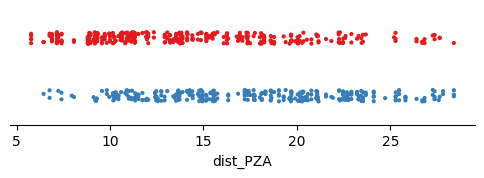

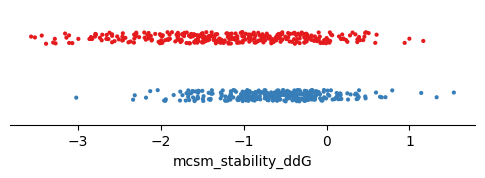

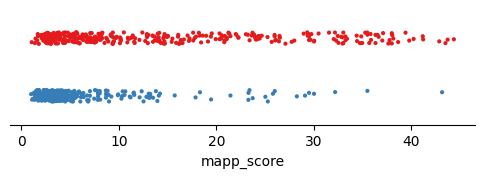

In [25]:
data_for_table = {}
data_for_table['feature'] = []
data_for_table['pvalue'] = []

for feature in ['d_volume', 'd_hydropathy_KD', 'd_Pi',
       'd_MW', 'd_rogov', 'phi', 'psi', 'residue_sasa', 'n_hbond_acceptors',
       'n_hbond_donors', 'temp_factor', 'depth',
       'deep_ddG', 'rasp_score_ml',
       'snap2_score', 'dist_FE2', 'dist_PZA',
       'mcsm_stability_ddG', 'mapp_score']:

    fig,axes=plt.subplots(1,1,figsize=(6,1.5))
    axes = seaborn.stripplot(data=dataset.df, x=feature, y='phenotype', size=3, palette={'S':'#377eb8', 'R':'#e41a1c'})
    # axes.set_xlim([-6.5,0.5])
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.get_yaxis().set_visible(False)
   
    (statistic, pvalue) = scipy.stats.mannwhitneyu(dataset.df[dataset.df.phenotype=='S'][feature], dataset.df[dataset.df.phenotype=='R'][feature])
    data_for_table['feature'].append(feature)
    data_for_table['pvalue'].append(pvalue)

    fig.savefig('pdf/figure-2/si-feature-scatter-' + feature + '.pdf',bbox_inches='tight',transparent=True)


In [26]:
df = pandas.DataFrame(data=data_for_table)
df['significant'] = df.pvalue<0.01
df.sort_values(by=['pvalue'])

,feature,pvalue,significant
14,snap2_score,8.845694e-41,True
12,deep_ddG,4.508713e-38,True
18,mapp_score,2.746952e-29,True
13,rasp_score_ml,7.955397e-28,True
7,residue_sasa,6.043365e-27,True
11,depth,1.308580e-24,True
16,dist_PZA,2.073373e-17,True
10,temp_factor,6.475745e-16,True
17,mcsm_stability_ddG,6.816325e-16,True
15,dist_FE2,1.889631e-12,True
